In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# ! unzip '/kaggle/input/medicalnotes-2019/data_split.zip'
# Any results you write to the current directory are saved as output.

In [28]:
TextList = [] #(filename, label, text)
path = 'dataset/train-data/'
import re
for label in os.listdir(path):
    for filename in os.listdir(path+label+'/'):
        file = path+label+'/'+filename
        try:
            with open(file, 'r') as f:
                text = f.readlines()
                parsetext = [] # list containing sentences
                for sentence in text:
                    if sentence == '\n':
                        pass
                    else:
                        for badcharacter in ['<B>\w{2}:', 'CC:', '<B>', '</B>', '\n']:
                            sentence = re.sub(badcharacter, '', sentence)
                        sentence = ''.join([s.lower() for s in sentence])
                        
                        parsetext.append(sentence)

            TextList.append((filename.strip('.txt'), label.strip(path), ''.join(parsetext)))
        except:
            pass

data = pd.DataFrame(TextList, columns = ['filename', 'label', 'text'])  
len(data)

811

## 1. Exploring BertTokenize

In [ ]:
data.iloc[120]

In [80]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
ts = tokenizer.tokenize(data.iloc[120]['text'])
### see that Bert tokenizer is doing
for t in ts:
    print(t, end = ' ')

exam : ct ku ##b . reason for exam : flank pain . technique : non ##con ##tra ##st ct abdomen and pe ##lvis per renal stone protocol . correlation is made with the prior examination dated 01 / 16 / 09 . findings : there is no intra ##ren ##al stone or obstruction bilateral ##ly . there is no hydro ##ne ##ph ##rosis , ur ##eter ##al dil ##ata ##tion . there are cal ##ci ##fication ##s about the pe ##lvis including one in the left upper pe ##lvis , but these are stable from the prior study and there is no upstream ur ##eter ##al dil ##ata ##tion , the findings therefore are favored to represent ph ##le ##bol ##ith ##s . the bladder is nearly completely deco ##mp ##ressed . there is no as ##ym ##metric renal en ##lar ##gement or per ##ine ##ph ##ric strand ##ing as secondary evidence of obstruction . the appendix is normal . there is no evidence for a per ##ico ##lon ##ic inflammatory process or small bow ##el obstruction . dedicated scan to the pe ##lvis disclosed the aforementioned pres

In [81]:
## to explore the frequency of words, let's tokenize all sentences in each paragraph using BERT tokenizer, 
## concatnate them back to sentence, and use the CountVectorizer from sklearn
sentences = data['text'].values.tolist()
labels = data['label'].values.tolist()

LabelList = []
SentenceList = []
from sklearn.feature_extraction.text import CountVectorizer
for sentence, label in zip(sentences, labels):

    encoded_sentence= tokenizer.tokenize(sentence) # tokenize using Bert tokenizer
    LabelList.append(label)
    encoded_sentence = ' '.join(encoded_sentence) # merge them back to sentence
    SentenceList.append(encoded_sentence)
    
## Here we count the occurence of each tokenizer. 
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(SentenceList).todense()
columns = vectorizer.get_feature_names()
X.shape

(811, 8762)

In [82]:
import pandas as pd
summarytable = pd.DataFrame(X, columns = columns)
summarytable['Label'] = LabelList
def findtopwords(df, label ='all', fromNth = 0, toNth = 1):
    if label !='all':
        assert label in df.Label.values, print('Label not found')
        df = summarytable[summarytable['Label']==label]
    return df.iloc[:, :-1].sum().reset_index(name= 'count').sort_values('count', ascending = False)[fromNth:toNth]

### Find top words 
for label in summarytable['Label'].unique():
    print(f'Common words for {label}')
    df = findtopwords(summarytable, label = label, fromNth=20, toNth=30)
    display(df)

Common words for Urology


,index,count
5464,or,273
6617,right,221
815,as,220
6036,procedure,215
1161,bladder,214
4453,left,204
7482,su,194
4000,ing,193
5834,placed,187
3520,had,186


Common words for Radiology


,index,count
6981,she,265
5678,patient,249
7791,this,244
569,al,224
2878,exam,205
815,as,196
649,an,195
8166,un,190
377,able,185
6429,rem,167


Common words for Orthopedic


,index,count
6981,she,689
5206,no,621
5598,pain,618
5464,or,609
4680,ly,597
5834,placed,553
1044,be,543
7766,there,518
5444,oper,506
7755,that,506


Common words for Gastroenterology


,index,count
7766,there,306
865,at,305
3571,he,300
5436,op,285
5408,on,283
569,al,267
3655,history,266
5508,os,264
2701,end,257
2812,es,255


Common words for Neurology


,index,count
8555,were,403
5678,patient,403
3563,has,374
7766,there,372
3650,his,356
3520,had,356
815,as,326
5229,not,312
4680,ly,307
5220,normal,299


## 2. Setting up and preparing data

In [ ]:
### Load required packages
import torch
import torch.optim as optim
import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformer
from transformers import BertModel, BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

### sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# split the data into train (that will be further splitted into train and val set), and a hold out test set
train, test = train_test_split(data, shuffle = True, stratify = data['label'], test_size = 0.25)

# FINE-TUNING BERT FOR CLASSIFICATION

In [ ]:
### choose model to work with
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)}
model_type = 'bert'
pretrained_model_name='bert-base-uncased'
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

2. ****Adapt Fastai library, Custom processor: The below code initializes a TokenizerProcessor and a NumericalizeProcessor with the wordpiece tokenizer and BERT vocabulary, then applies it to each piece of text in the dataframe.****

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens
        
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [ ]:
### customize fastai tokenizer
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

### customize fastai processor, including tokenize_processor, numericalize_processor
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer) #get vocabulary
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab) #numericalize
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False) 

transformer_processor = [tokenize_processor, numericalize_processor]

**3. Setting up the Databunch (processing data and put to dataloader)**

In [ ]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id
databunch = (TextList.from_df(train, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= 'label')
             .add_test(test)
             .databunch(bs=16, pad_first=pad_first, pad_idx=pad_idx))

In [ ]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

![text](token1.jpg)

In [ ]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

![text](token2.jpg)

In [ ]:
torch.cuda.is_available()

In [ ]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0]   
        return logits

In [ ]:
use_fp16 = False
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)

![text](configBert.jpg)

In [ ]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)


Learner: optimizer 

In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [ ]:
learner.save('untrain')

In [29]:
learner.load('untrain');

In [30]:
learner.model

CustomTransformerModel(
  (transformer): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feature

In [31]:
list_layers = [learner.model.transformer.bert.embeddings,
              learner.model.transformer.bert.encoder.layer[0],
              learner.model.transformer.bert.encoder.layer[1],
              learner.model.transformer.bert.encoder.layer[2],
              learner.model.transformer.bert.encoder.layer[3],
              learner.model.transformer.bert.encoder.layer[4],
              learner.model.transformer.bert.encoder.layer[5],
              learner.model.transformer.bert.encoder.layer[6],
              learner.model.transformer.bert.encoder.layer[7],
              learner.model.transformer.bert.encoder.layer[8],
              learner.model.transformer.bert.encoder.layer[9],
              learner.model.transformer.bert.encoder.layer[10],
              learner.model.transformer.bert.encoder.layer[11],
              learner.model.transformer.bert.pooler]
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(30522, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): Embedding(2, 768)
  (3): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_fea

In [32]:
learner.freeze_to(-1)
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [512, 768]           23,440,896 False     
______________________________________________________________________
Embedding            [512, 768]           393,216    False     
______________________________________________________________________
Embedding            [512, 768]           1,536      False     
______________________________________________________________________
LayerNorm            [512, 768]           1,536      False     
______________________________________________________________________
Dropout              [512, 768]           0          False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
_______________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 3.98E-07


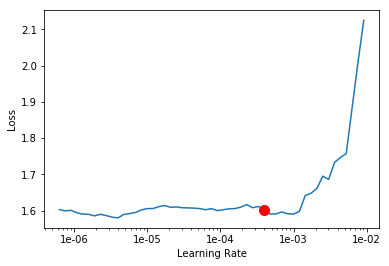

In [33]:
learner.lr_find()
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.535966,1.279285,0.454545,0.545455,00:10


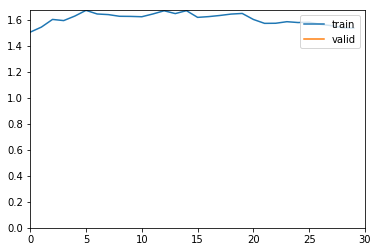

In [34]:
learner.fit_one_cycle(1,max_lr=3e-04,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.303866,1.108446,0.528926,0.471074,00:11


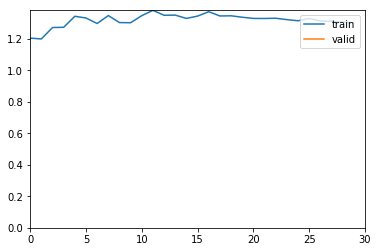

In [35]:
learner.fit_one_cycle(1,max_lr=3e-04,moms=(0.8,0.7))

In [36]:
learner.save('first_cycle')
learner.load('first_cycle')

Learner(data=TextClasDataBunch;

Train: LabelList (487 items)
x: TextList
[CLS] chief complaint : right middle finger triggering and locking , as well as right index finger sore ##ness at the pip joint . history of occupational injury or illness : the patient has been followed elsewhere , and we reviewed his records . essentially , he has had a trigger finger and a mu ##co ##cy ##st , and he has had injection ##s . this has been going on for several months . he is now here for active treatment because the injection ##s were not helpful , non ##oper ##ative treatment has not worked , and he would like to move forward in order to prevent this from keeping on locking and causing his pain . he is referred over here for evaluation regarding that . significant past medical and surgical history : general health / review of systems : see h & p . all ##er ##gies : see h & p . medications : see h & p . social history : see h & p . family history : see h & p . previous hospital ##izations : see h

In [37]:
learner.freeze_to(-2)
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [512, 768]           23,440,896 False     
______________________________________________________________________
Embedding            [512, 768]           393,216    False     
______________________________________________________________________
Embedding            [512, 768]           1,536      False     
______________________________________________________________________
LayerNorm            [512, 768]           1,536      False     
______________________________________________________________________
Dropout              [512, 768]           0          False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
_______________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-05
Min loss divided by 10: 2.29E-05


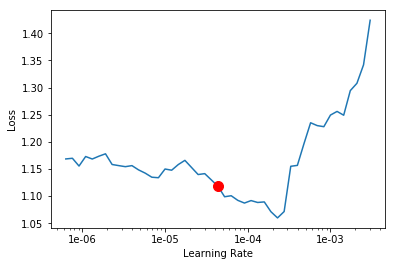

In [38]:
learner.lr_find()
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.097176,0.799059,0.644628,0.355372,00:12
1,0.877666,0.799806,0.685950,0.314050,00:12
2,0.704606,0.563376,0.785124,0.214876,00:12
3,0.552445,0.592910,0.760331,0.239669,00:11
4,0.473828,0.585398,0.752066,0.247934,00:12


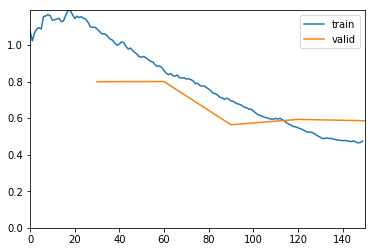

In [39]:
lr = 4e-5
num_groups = len(learner.layer_groups)
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [40]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

#test_preds = get_preds_as_nparray(DatasetType.Test)


In [41]:
test_preds = get_preds_as_nparray(DatasetType.Test)
classList = databunch.classes
test['predict'] = np.argmax(test_preds,axis=1)
test['target'] = test['label'].apply(lambda x: classList.index(x))
test

,filename,label,text,predict,target
627,1792,Gastroenterology,preoperative diagnosis: blood loss anemia.pos...,0,0
699,1699,Neurology,reason for consultation: new-onset seizure.hi...,1,1
715,1327,Neurology,reason for consult: essential tremor and tort...,1,1
226,1428,Radiology,exam: bilateral renal ultrasound.clinical ind...,4,3
15,1399,Urology,preoperative diagnoses:1. urinary retention.2...,4,4
...,...,...,...,...,...
724,1071,Neurology,discharge diagnoses:1. bilateral lower extrem...,4,1
602,1771,Gastroenterology,preoperative diagnoses: malnutrition and dysp...,0,0
566,1580,Gastroenterology,admitting diagnosis: gastrointestinal bleed.h...,0,0
195,1339,Radiology,indications: abnormal ekg.stress technique...,3,3


In [ ]:
test[:3]

In [42]:
confusion_matrix(test['predict'], test['target'])

array([[38,  1,  0,  4,  1],
       [ 0, 15,  1,  5,  0],
       [ 0,  0, 48,  3,  0],
       [ 1, 18,  6, 33,  0],
       [ 0,  1,  0,  1, 27]])

In [43]:
a = classification_report(test['predict'], test['target'])
print(a)

              precision    recall  f1-score   support

           0       0.97      0.86      0.92        44
           1       0.43      0.71      0.54        21
           2       0.87      0.94      0.91        51
           3       0.72      0.57      0.63        58
           4       0.96      0.93      0.95        29

    accuracy                           0.79       203
   macro avg       0.79      0.80      0.79       203
weighted avg       0.82      0.79      0.80       203



# Universal Language Model Fine-tuning (ULMFiT)**

## 1. Prepare data

In [44]:
train[:3]

,filename,label,text
398,1523,Orthopedic,chief complaint: right middle finger triggeri...
527,1107,Gastroenterology,"primary diagnosis: esophageal foreign body, n..."
651,1014,Gastroenterology,operation1. ivor-lewis esophagogastrectomy.2....


In [45]:
## Create a TextDataBunch suitable for training a language model.
## All the texts in the datasets are concatenated and the labels are ignored. Instead, the target is the next word in the sentence
train_df , valid_df = train_test_split(train, shuffle = True, stratify = train['label'], test_size = 0.10) # only use 10% here as we focus more on training
databunchLM = (TextLMDataBunch.from_df('.', train_df , valid_df, 
                                       text_cols = 'text', label_cols = 'label')) # as we need to specify train_df and valid_df, a trick is to slide data 
databunchLM.save()

In [ ]:
databunchLM.show_batch()

#### By default, fastai use spacy tokenizer
The rules are all listed below, here is the meaning of the special tokens:

UNK (xxunk) is for an unknown word (one that isn't present in the current vocabulary)

PAD (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch

BOS (xxbos) represents the beginning of a text in your dataset

FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)**

TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text

TK_UP (xxup) is used to indicate the next word is written in all caps in the original text

TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})

TK_WREP(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

In [46]:
len(databunchLM.vocab.itos) #all words in the data 8888

8912

In [74]:
# transformer, transformerXL
learner = language_model_learner(databunchLM, AWD_LSTM, drop_mult=0.3,pretrained=True)

In [76]:
learner.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(8912, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(8912, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=8912, bias=True)
    (output_dp): RNNDropout()
  )
)

In [73]:
learner.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 8912]           3,573,712  True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 3,573,712
Total trainable params: 3,573,712
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss func

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.63E-02


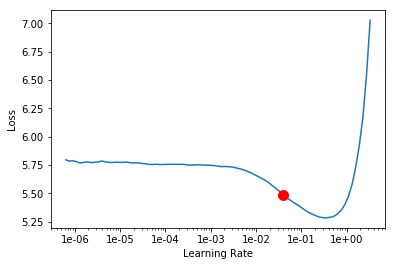

In [48]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [49]:
learner.fit_one_cycle(2, 3e-02,callbacks=[SaveModelCallback(learner, name="best_lm")], moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.418882,3.810041,0.327065,00:08
1,3.479266,3.526179,0.353823,00:08


Better model found at epoch 0 with valid_loss value: 3.8100414276123047.
Better model found at epoch 1 with valid_loss value: 3.5261785984039307.


In [50]:
learner.save('fit_head')

In [51]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-03


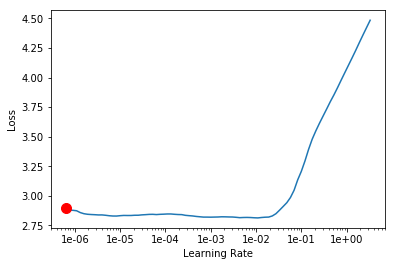

In [52]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [54]:
learner.fit_one_cycle(3,1e-05,callbacks=[SaveModelCallback(learner, name="best_lm")], moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.824466,3.520030,0.355776,00:08
1,2.814265,3.515318,0.355497,00:08
2,2.807038,3.519766,0.354129,00:08


Better model found at epoch 0 with valid_loss value: 3.5200300216674805.
Better model found at epoch 1 with valid_loss value: 3.515317916870117.


In [55]:
learner.load('best_lm')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (547 items)
x: LMTextList
xxbos preoperative diagnosis : right chronic subdural hematoma.postoperative diagnosis : right chronic subdural xxunk of operation : right burr hole craniotomy for evacuation of subdural hematoma and placement of subdural xxunk : general endotracheal anesthesia.estimated blood loss : 100 xxunk procedure : in preoperative identification , the patient was taken to the operating room and placed in supine position . following induction of satisfactory general endotracheal anesthesia , the patient was prepared for surgery . table was turned . the right shoulder roll was placed . the head was turned to the left and xxunk on a doughnut . the scalp was shaved , and then prepped and draped in usual sterile fashion . incisions were marked along a xxunk right frontotemporal craniotomy xxunk and over the parietal boss . the parietal boss incision was opened . it was about an inch and a half in length . it was carried

In [56]:
learner.save_encoder('enc')

### 2. Transfer learning: Use the encoder part for the classification model

In [57]:
len(databunchLM.train_ds.vocab.itos)

8912

In [58]:
### set up data for classificaiton
databunchCLS  = TextClasDataBunch.from_df('.', 
                                       train_df=train_df,valid_df=valid_df, test_df = test,
                                       text_cols='text',label_cols='label',vocab=databunchLM.train_ds.vocab)


In [79]:
#TransferLearner = text_classifier_learner(databunchCLS, AWD_LSTM, drop_mult=0.3)
TransferLearner = text_classifier_learner(databunchCLS, AWD_LSTM, drop_mult=0.3)
TransferLearner.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(8912, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(8912, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.12, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, e

In [60]:
TransferLearner.load_encoder('enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (547 items)
x: TextList
xxbos preoperative diagnosis : right chronic subdural hematoma.postoperative diagnosis : right chronic subdural xxunk of operation : right burr hole craniotomy for evacuation of subdural hematoma and placement of subdural xxunk : general endotracheal anesthesia.estimated blood loss : 100 xxunk procedure : in preoperative identification , the patient was taken to the operating room and placed in supine position . following induction of satisfactory general endotracheal anesthesia , the patient was prepared for surgery . table was turned . the right shoulder roll was placed . the head was turned to the left and xxunk on a doughnut . the scalp was shaved , and then prepped and draped in usual sterile fashion . incisions were marked along a xxunk right frontotemporal craniotomy xxunk and over the parietal boss . the parietal boss incision was opened . it was about an inch and a half in length . it was carried down

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 3.63E-02


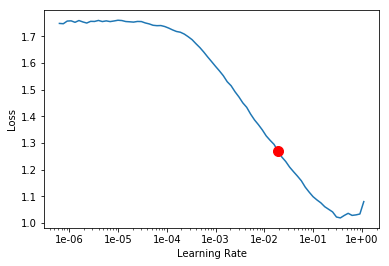

In [61]:
TransferLearner.lr_find()
TransferLearner.recorder.plot(suggestion=True)

In [62]:
TransferLearner.fit_one_cycle(3,2e-02, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.199797,1.249814,0.491803,00:11
1,0.894213,0.947687,0.622951,00:12
2,0.754184,0.895324,0.688525,00:11


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.31E-03


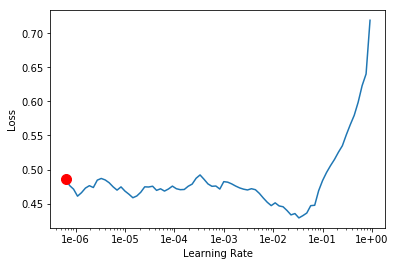

In [63]:
TransferLearner.freeze_to(-2)
TransferLearner.lr_find()
TransferLearner.recorder.plot(suggestion=True)
#TransferLearner.fit_one_cycle(3, best_clf_lr)

In [64]:
TransferLearner.fit_one_cycle(3,2e-03, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.524565,0.870601,0.622951,00:10
1,0.465427,0.794761,0.672131,00:11
2,0.422325,0.730928,0.704918,00:11


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.37E-04


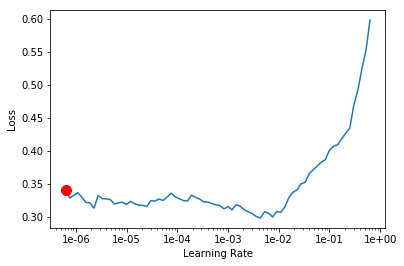

In [65]:
TransferLearner.unfreeze()
TransferLearner.lr_find()
TransferLearner.recorder.plot(suggestion=True)

In [66]:
TransferLearner.fit_one_cycle(3,1e-03, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.334071,0.795268,0.655738,00:11
1,0.309393,0.826393,0.704918,00:11
2,0.290137,0.804231,0.688525,00:10


In [67]:
classList = databunchCLS.classes
classList

['Gastroenterology', 'Neurology', 'Orthopedic', 'Radiology', 'Urology']

### 3. Making predictions on test set

In [68]:
print(len(test))
test[:3]

203


,filename,label,text,predict,target
627,1792,Gastroenterology,preoperative diagnosis: blood loss anemia.pos...,0,0
699,1699,Neurology,reason for consultation: new-onset seizure.hi...,1,1
715,1327,Neurology,reason for consult: essential tremor and tort...,1,1


In [69]:
true, pred = [], []
for index, row in test.iterrows(): 
    tr = classList.index(row[1])
    p = TransferLearner.predict(row[2])[1].item()
    pred.append(p)
    true.append(tr)


In [70]:
confusion_matrix(true, pred)

array([[32,  1,  0,  4,  2],
       [ 0, 19,  3, 13,  0],
       [ 1,  3, 46,  5,  0],
       [ 2, 12,  4, 25,  3],
       [ 0,  3,  0,  0, 25]])

In [71]:
a = classification_report(true, pred)
print(a)

              precision    recall  f1-score   support

           0       0.91      0.82      0.86        39
           1       0.50      0.54      0.52        35
           2       0.87      0.84      0.85        55
           3       0.53      0.54      0.54        46
           4       0.83      0.89      0.86        28

    accuracy                           0.72       203
   macro avg       0.73      0.73      0.73       203
weighted avg       0.73      0.72      0.73       203

